# Beautiful Soup
## An introduction to Webscraping
### By Lena Hajjar, with additions by Jeff Parker

<p> Many of you have expressed interest in processing information found on websites</p>
<p> There are many options, but the library that is mentioned most often is Beautiful Soup</p>

#### Some Basics
Beautiful Soup has an excellent website, with full documentation.  See https://www.crummy.com/software/BeautifulSoup/bs4/doc/ 

<b> NOTE: </b> Webscraping may be against the terms and conditions of some websites (Yelp, FB, etc). Sometimes it's because they offer the services for a fee (Twitter, Facebook, etc) - so if you really want the information and really don't want to break the terms & conditions (or get your IP address banned from the website), you can try getting the information through the recommended sources. The rules are really made to prevent people from doing mass scrapings for profit - I doubt they would bother tracking down the graduate student scraping one or two pages for educational purposes. 

<b> robots.txt </b> The convention is that the publisher will list the rules in a file called robots.txt at the root of the website.  

In [1]:
from bs4 import BeautifulSoup
import requests

# first, we want to read the rules of the road
webpage = requests.get("https://www.movieforums.com/robots.txt")
webtext = webpage.text
print(webtext)

User-agent: *
Disallow: /scripts/
Disallow: /cgi-bin/
Disallow: /community/admin/
Disallow: /community/images/
Disallow: /community/mod/
Disallow: /community/avatar.php
Disallow: /community/editpost.php
Disallow: /community/member2.php
Disallow: /community/moderator.php
Disallow: /community/newreply.php
Disallow: /community/newthread.php
Disallow: /community/online.php
Disallow: /community/postings.php
Disallow: /community/private.php
Disallow: /community/register.php
Disallow: /community/report.php
Disallow: /community/threadrate.php
Disallow: /community/usercp.php


## Is our use legitimate?
What does that mean for us?  Is this use legitimate?  We can use the robotparser library to check.  

We demonstrate below, checking if we can scrape the Extension School site.

In [2]:
import urllib.robotparser
rp = urllib.robotparser.RobotFileParser()
rp.set_url("https://www.extension.harvard.edu/robots.txt")
rp.read()
print(rp.can_fetch("*", "https://www.extension.harvard.edu/"))

True


#### Let's start at the beginning:
Let's say we want to look at a thread in movieforums.com about the movie Die Hard.  Here is a thread we will process: https://www.movieforums.com/community/showthread.php?t=49209

In [3]:
from bs4 import BeautifulSoup
import requests

# first, we should request the webpage
webpage = requests.get("https://www.movieforums.com/community/showthread.php?t=49209")
webtext = webpage.text
# We can print it, but it isn't very useful
print(webtext)

<!DOCTYPE html>
<html xmlns="http://www.w3.org/1999/xhtml" dir="ltr" lang="en">
<head>
<title> Is Die Hard (1988) overrated? - Movie Forums</title>



<meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=yes"/>
<meta http-equiv="Content-Type" content="text/html; charset=charset=utf-8" />
<meta http-equiv="X-UA-Compatible" content="IE=edge" >
<!-- Whatever you do, do NOT put other stuff above the IE=edge tag -->

<link rel="apple-touch-icon-precomposed" sizes="196x196" href="/apple-touch-icon-precomposed.png?v=2" />
<link rel="apple-touch-icon" sizes="57x57"   href="/apple-touch-icon-57x57.png?v=2">
<link rel="apple-touch-icon" sizes="60x60"   href="/apple-touch-icon-60x60.png?v=2">
<link rel="apple-touch-icon" sizes="72x72"   href="/apple-touch-icon-72x72.png?v=2"> 
<link rel="apple-touch-icon" sizes="76x76"   href="/apple-touch-icon-76x76.png?v=2"> 
<link rel="apple-touch-icon" sizes="114x114" href="/apple-touch-icon-114x114.png?v=2"> 
<link rel="apple-t

In [4]:
print(type(webtext))

<class 'str'>


In [ ]:
#Now we have the ingredients - let's make the soup!
soup = BeautifulSoup(webtext, "html.parser") 
# I just passed the string with all of the html data, and asked to use the html parser

In [ ]:
#you can ask beautiful soup to print everything it parsed

print(soup.prettify())

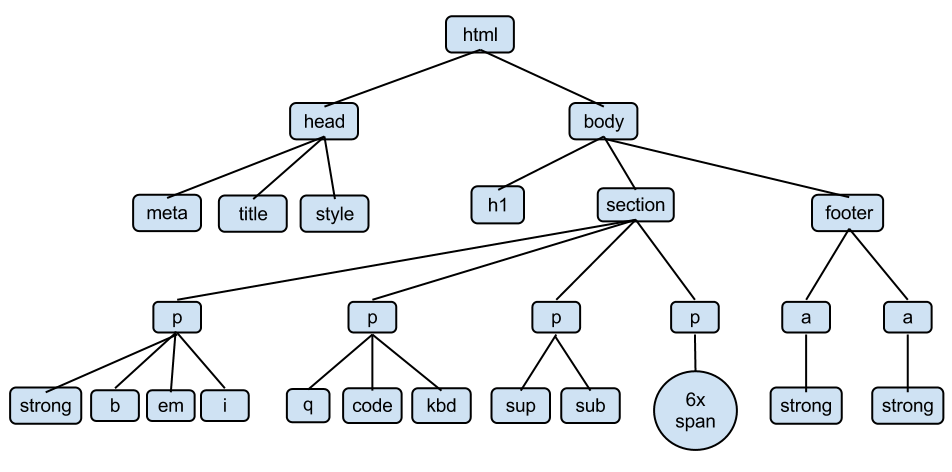

In [5]:
# What is the organization of a webpage?
from IPython.display import Image
Image('http://www.openbookproject.net/tutorials/getdown/css/images/lesson4/HTMLDOMTree.png')

In [ ]:
# Cool! we have our soup- now let's see what's in it. 
# You can look for a tag itself (like the title tag)
print(soup.title) #notice that the tags are still here
print("===========================")
print(soup.title.string) #cool, now we know how to get the text inbetween the tags!
print("===========================")
print(soup.div)
print("===========================")
print(soup.div['class']) #you can ask for an attribute 
print("===========================")
print(soup.a)
print("===========================")
print(soup.a['href']) #cool, a new link! 

# note that this only returns the first instance of each tag specified! 

In [ ]:
# what if we wanted ALL links?
links = soup.find_all('a')
print(links) # this looks kind of ugly. What's happening here?
print("===========================")
print(type(links)) #it's a set!
print("===========================")

# say I wanted to find out all the links and text displayed
for i in links:
     print(i['href'], ":", i.string)

In [ ]:
# we got a key error! I should probably deal with that error

for i in links:
    try:
        print(i['href'], ":", i.string)
    except KeyError:
        pass # I don't care mwhat happens to links without 'href's, so I skip them        

In [6]:
# you could also get all the text on the page (problem solved, right?)
soup.get_text()

NameError: name 'soup' is not defined

Problems with this "solution":
<ul>
<li> It's ugly </li>
<li> Everything is smushed together - you don't know who said what or when. </li>
<li> You literally have all the text including..
<ul>
<li>quotes (that'd be repeated text)</li> 
<li>signatures (meaningless to the question) </li>
<li>and all the text that is a part of the webpage! </li>
</ul>
</ul>

<p> So it looks like what we really want to do is find each post, and then get the information we want from it</p> 

In [ ]:
## after doing some detective work, we discovered that posts are found in div tags with class 'post'.

allDiv = soup.find_all('div') # all div's
postDivs = [] # empty list
postDateDivs = []
postTextDivs = []

for div in allDiv:
    try:
        if 'post' in div.get('class'): # if it's a post, add to post list
            postDivs.append(div)
        elif 'postdate' in div.get('class'): # if it's a date, add to date list
            postDateDivs.append(div)
        elif 'posttext' in div.get('class'): # if it's text, add to text list
            postTextDivs.append(div)
    except Exception:
        pass

In [ ]:
postTextDivs.pop(1) # the advertisement is always the second post
postDivs.pop(1) # the advertisement is always the second post

print(len(postDivs))
print(len(postDateDivs))
print(len(postTextDivs))
print(postDivs)
print("+++++++++++++")
print(postDateDivs)
print("+++++++++++++")
print(postTextDivs)


<b>Awesome,</b> we now have all the posts. Now we need to figure out what information we actually want from the posts. 
For the sake of doing all of this to get something meaningful, I've decided that my goal is to get the following:
<ul>
<li>Username</li>
<li>TimeStamp</li>
<li>Post</li>
</ul>



In [ ]:
## Starting with the username. 
## After some sluething, we found out that usernames are in the a tag with class 'username'
## Let's make this a function!

def findUserName(postDiv):
    allPostLinks = postDiv.find_all('a')
    # iterate through all links
    for link in allPostLinks:
        try:
            if 'username' in link.get('class'): # if class type is username, get the name!
                return link.text
        except Exception:
            pass
    return None

## test...
for post in postDivs:
    print(findUserName(post))

In [ ]:
## now let's find the timestamp

def findTimeStamp(postDateDiv):
    try: # we know the time stamp is the title of date items
        return postDateDiv.a['title']
    except Exception:
        return None

for div in postDateDivs:
    print(findTimeStamp(div))    

In [ ]:
## now for the actual text..

def findText(postTextDiv):
    """ This function finds all text, and all the text that was quoted from someplace else
        It finds the text, erases all quoted text, and then returns the remaining, original text."""
    allText = None 
    quotedText = None
    postDivs = postTextDiv.find_all('div')
    #find text
    for div in postDivs:
        try: 
            if "post_message" in div['id']:
                allText = div.get_text()
        except Exception:
            pass
        try: #if any text was quoted, we need to save it so we can remove it from all text
            if "quotecontainer" in div.get('class'):
                quotedText = div.get_text()
                #print(quotedText)
        except Exception:
            pass

    # print(allText, "\n", quotedText)
    # if the post isn't quoting anything, return the post text
    if quotedText == None: 
        allText = allText.replace(",", "")
        return allText
    else: #otherwise you need to remove the quoted text 
        allText = allText.replace(quotedText,"")
        allText = allText.replace(",", "")
        return allText
    
for div in postTextDivs:
    print(findText(div))

In [ ]:
## okay! Now that we know how to find all the info we want, we can make a csv file! 
allUserNames  = [findUserName(div) for div in postDivs]
allTimeStamps = [findTimeStamp(div) for div in postDateDivs]
allText       = [findText(div) for div in postTextDivs]
print(len(allUserNames), len(allTimeStamps), len(allText))

In [ ]:
## now write to csv file..
import csv

allRows = []
for username, timestamp, text in zip(allUserNames, allTimeStamps, allText):
    allRows.append([username, timestamp, text.strip()])

#print(allRows)
with open("DieHardData2.csv", "a", encoding = "utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["UserName", "TimeStamp", "Text"])
    for row in allRows:
        writer.writerow(row)

Look in your directory to for the csv file.  

In [ ]:
# What about the next page? The link to the next page is indcated with a '>>'

def findNextPage(allLinks):
    for link in allLinks:
        if link.get_text() == "»":
            return "https://www.movieforums.com/community/"+ link['href']
    ## if we get all the way to end and didn't find it, assume it's the end of the forum
    return None

print(findNextPage(links))


#### Cool! We got all the pieces ~ now we should put them together into a nice, neat set of funcitons. 

In [ ]:
def scrapeForum(url, fileName):
    """ This takes a forum from movieforum.com and scrapes all entries. 
        It then creates a file with the Usernames, TimeStamp, and Text of each entry. """
    
    ## first, open the page:
    webpage = requests.get(url)
    webtext = webpage.text
    
    ## now let's make some soup
    soup = BeautifulSoup(webtext, "html.parser") 
    
    ## get links for future reference
    links = soup.find_all('a')
    
    ## now find all the right div sections:
    allDiv       = soup.find_all('div') #all div's
    postDivs     = [] #empty list
    postDateDivs = []
    postTextDivs = []

    for div in allDiv:
        try:
            if 'post' in div.get('class'):
                postDivs.append(div)
            elif 'postdate' in div.get('class'):
                postDateDivs.append(div)
            elif 'posttext' in div.get('class'):
                postTextDivs.append(div)
        except Exception:
            pass
    
    ## we already described the functions to find the username, timestamp, and text, so let's use them!!
    allUserNames = [findUserName(div) for div in postDivs]
    allTimeStamps = [findTimeStamp(div) for div in postDateDivs]
    allText = [findText(div) for div in postTextDivs]
    
    ## create the rows for the csv file
    allRows = []
    for username, timestamp, text in zip(allUserNames, allTimeStamps, allText):
        allRows.append([username, timestamp, text.strip()])
    
    ## print to file! 
    with open(fileName, "a", encoding = "utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["UserName", "TimeStamp", "Text"])
        for row in allRows:
            writer.writerow(row)
            
    ## almost done - now we should check for a next page. If there is, call this function again.
    ## If not, then we can just call it a day. 
    
    nextPage = findNextPage(links)
    if nextPage != None:
        scrapeForum(nextPage, fileName) ## since we open the fileName using 'a', it'll just append to the end
   
    return

In [ ]:
scrapeForum("https://www.movieforums.com/community/showthread.php?t=49209", "DieHardForum2.csv")

In [ ]:
scrapeForum("https://www.movieforums.com/community/showthread.php?t=45018", "pirate2.csv")

### Results
<p> We can successfully scrape a whole web forum! </p>
<p> Some things to remember </p>
<ul> 
<li> This will ONLY work for movieforums.com. We other website may not have the same tags </li>
<li> It takes a bit of effort to make the script, but it's WORTH IT </li>
<li> This script may have to be changed over time.  Websites get updated, and so do the HMTL tags in it </li>
<li> Beautiful Soup does not work for websites written with javascript. </li>
<li> Overall, it's pretty cool!</li>
<ul>



## Thanks, Lena!